In [1]:
import os
import numpy as np
import scipy as sp
from scipy.optimize import leastsq, minimize
import matplotlib.pyplot as plt

from scipy.io import loadmat
from datetime import datetime
from collections import defaultdict
import scipy.ndimage as ndi
import pickle
%matplotlib inline

In [2]:
from pysquid.rnet import ResistorNetworkModel
from pysquid.model import FluxModelTVPrior
from pysquid.linearModel import *
from pysquid.kernels.magpsf import GaussianKernel
from pysquid.util.helpers import *
import pysquid.viz.fake_data_plotting as fpd
from pysquid.opt.varbayes import Varbayes

from pysquid.gendata.fake_data import make_fake_data

In [3]:
import pysquid.infercurrents.deconvolve as deconvolve

## Parameters that the fake data was made with:

In [4]:
fakedata_file = '../pysquid/gendata/fake_data.npz'
if not os.path.exists(fakedata_file):
    make_fake_data()

In [158]:
fakefile = np.load(fakedata_file)
fakescan = fakefile['image_flux']
fake_g = fakefile['image_g']
fake_g_all = fakefile['all_g']
fake_offset = fakefile['offset']
fake_J_ext = fakefile['J_ext']
fake_psf = fakefile['psf_params']

sigma = 0.02
noise = np.random.normal(0., sigma, size=fakescan.shape)
norm = np.max(np.abs(fakescan))
fakescan = fakescan/norm
Ly, Lx = fakescan.shape

fakedata = fakescan + noise
fake_g = fake_g/norm

#matshow(fakedata, aspect=0.5);
#matshow(fake_g, aspect=0.5);

In [6]:
mask = np.load('../pysquid/gendata/fake_data_hallprobe_interpolated.npy')
#plt.matshow(mask, cmap='Greys', aspect=0.2)

In [159]:
interpmask = 2.*mask-1
align = interpmask.copy()
yc, xc = fake_offset
align[yc:yc+Ly, xc:xc+Lx] *= fakescan

#fig, ax = plt.subplots(1,1, figsize=(10,10))
#lim = np.abs(fakescan).max()
#ax.matshow(align, cmap='Greys', aspect=0.2, vmin=-lim, vmax=lim)
#plt.savefig('../plots/fake_exterior.png',dpi=200)

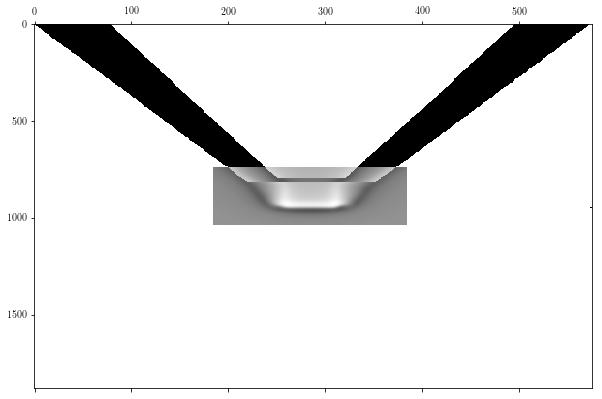

In [160]:
fakemask = mask.copy()
cut = 80
width = 20
startx, endx = 230, 350

fakemask[yc+cut:yc+Ly, xc:xc+Lx] = 0.
fakemask[yc+cut-width:yc+cut, startx:endx] = np.ones((width,endx-startx))

fig, ax = plt.subplots(1,1, figsize=(10,10))
interpmask = 2.*fakemask-1
align = interpmask.copy()
yc1, xc1 = np.array(fake_offset)-np.array([0,0])
align[yc1:yc1+Ly, xc1:xc1+Lx] *= fakescan

lim = np.abs(fakescan).max()
ax.matshow(align, cmap='Greys', aspect=0.2, vmin=-lim, vmax=lim)

## Fitting TV model

In [154]:
psf_params = fake_psf
#param_dict = {'psf_params': fake_psf,
#              'J_ext': np.array([np.max(fake_g)/np.max(netmodel.gfield)]),
#              'sigma': np.array([0.02])}

In [ ]:
#TODO: FIX EXTERNAL LOOP SUBTRACTION!

In [155]:
kernel = GaussianKernel(fakedata.shape, params=psf_params, rxy=2.)
netkernel = GaussianKernel(fakemask.shape, params=psf_params)

netmodel = ResistorNetworkModel(fakemask, kernel=netkernel, phi_offset = [yc1, xc1], 
                                gshape=(Ly, Lx), electrodes=[50,550])
J_ext = fakedata[0].dot(netmodel.ext_flux[0])/np.sum(netmodel.ext_flux[0]**2)

In [277]:
J_ext = 3.6*fakescan[0].dot(netmodel.ext_flux[0])/np.sum(netmodel.ext_flux[0]**2)
print(J_ext)

5156.814376212821


In [278]:
netmodel.updateParams('J_ext', [J_ext])
fitflux_sub = fakedata.ravel() - netmodel.ext_flux.ravel()

In [279]:
fitflux_sub = fakedata.ravel() - netmodel.ext_flux.ravel()

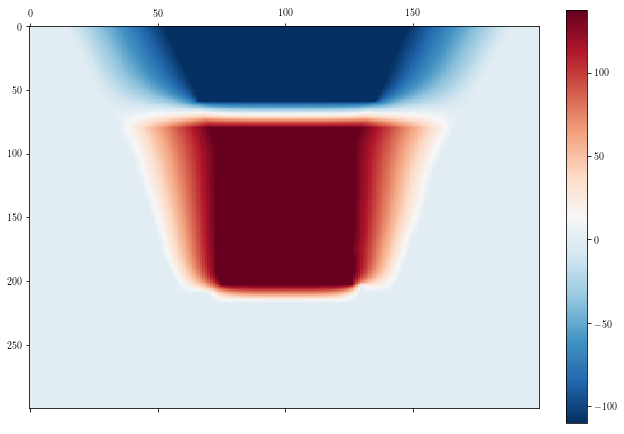

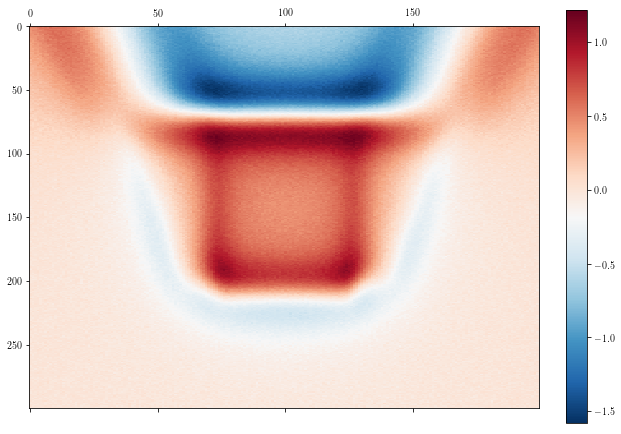

(<Figure size 720x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fad9d6d35c0>)

In [280]:
matshow(fake_g - 1.8*netmodel.g_ext, 0.5)
matshow(fitflux_sub.reshape(kernel._shape), 0.5)

In [19]:
model = FluxModelTVPrior(fakedata, param_dict=param_dict, extmodel=netmodel, 
                         mu_reg=.5, rxy=2., padding=(0,0))#(10, 6))

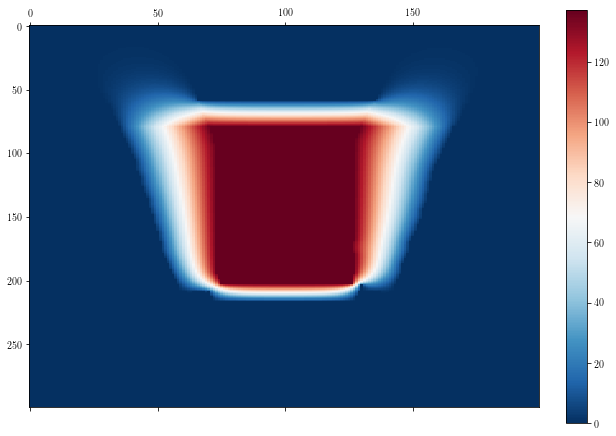

(<Figure size 720x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fdea134ff28>)

In [21]:
py, px = model.py, model.px
Ly_pad, Lx_pad = model.Ly_pad, model.Lx_pad
oy, ox = fake_offset
true_g = fake_g_all[oy-py:oy-py+Ly_pad,
                    ox-px:ox-px+Lx_pad]*fake_J_ext[0]/norm
realg = true_g.ravel()- model.extmodel.g_ext.ravel()#+0.001*np.random.randn(model.N_pad)
matshow(realg.reshape(model.Ly_pad,-1), 0.5)

Text(0.5, 1.05, '$\\phi$-$\\phi_{\\mathrm{ext}}$')

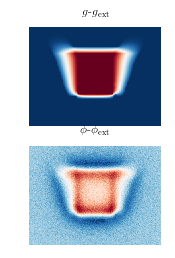

In [14]:
fig, axes = plt.subplots(2,1)
axes[0].matshow(realg.reshape(model.Ly_pad,-1), aspect = 0.5)
axes[0].set_title('$g$-$g_\mathrm{ext}$'); axes[0].axis('off')
axes[1].matshow((model.fluxdataflat-
                 model.crop(model.extmodel.ext_flux.ravel())).reshape(model.Ly,-1),
                aspect = 0.5); axes[1].axis('off')
axes[1].set_title('$\phi$-$\phi_{\mathrm{ext}}$')
#plt.savefig('../docs/2016aps/figs/g-gext.pdf', dpi=200)

In [22]:
admm = LinearModelTV_ADMM(model, rho=1E-1, mu_reg=1)
admm.sigma = model.sigma
startg = np.random.randn(model.N_pad)/np.sqrt(model.N_pad)

In [16]:
fitflux = model.fluxdataflat-model.crop(model.extmodel.ext_flux.ravel())
#startg = realg + 1E-8*np.random.randn(model.N_pad)
#startg = np.random.randn(model.N_pad)/np.sqrt(model.N_pad)
admm.computeNLL(fitflux, startg, model.extmodel.ext_g.ravel())

gmin = admm.solve(fitflux, startg, extmodel = model.extmodel,
                  itnlim = 1, iprint = 2, abs_tol = 1E-6, rel_tol = 1E-6)

Initial NLL = 6336342.540958953
	Itn 0: NLL = 5.250686e+06, r = 2.330e+07,  s = 3.188e-01, eps_p = 2.328e+01, eps_d = 2.449e-04
Final NLL = 5250685.872363468


In [89]:
decon0 = deconvolve.TVDeconvolver(kernel, 1.6 * param_dict['sigma'][0], g_ext=netmodel.g_ext)

In [91]:
cost0 = []
def callback0(x, z, y, costlist = cost0, **kwargs):
    costlist += [decon0.cost(x, decon0.A.dot(x) - decon0.c, (fitflux_sub,))]
startg = np.random.randn(kernel.N_pad)/np.sqrt(kernel.N_pad)

gsol0 = decon0.deconvolve(fitflux_sub, startg, iprint=2, itnlim=40, rho=1.E-4,
                          eps_abs=1E-6, eps_rel=1E-6, algorithm='minimize',
                          callback=callback0)

Initial cost = 2.611e+03
Itn 0: cost = 3.231e+05, rho = 0.0002
	r = 2.943e+12, s = 2.656e-01 
Itn 1: cost = 4.748e+03, rho = 0.0004
	r = 2.604e+05, s = 1.063e+00 
Itn 2: cost = 6.480e+01, rho = 0.0008
	r = 2.202e+04, s = 1.499e-03 
Itn 3: cost = 5.490e+01, rho = 0.0016
	r = 3.835e+03, s = 1.860e-03 
Itn 4: cost = 5.157e+01, rho = 0.0032
	r = 6.243e+02, s = 2.311e-03 
Itn 5: cost = 5.071e+01, rho = 0.0064
	r = 1.609e+02, s = 2.605e-03 
Itn 6: cost = 5.046e+01, rho = 0.0128
	r = 5.105e+01, s = 3.286e-03 
Itn 7: cost = 5.050e+01, rho = 0.0256
	r = 1.636e+01, s = 4.434e-03 
Itn 8: cost = 5.053e+01, rho = 0.0512
	r = 4.652e+00, s = 5.113e-03 
Itn 9: cost = 5.057e+01, rho = 0.1024
	r = 1.346e+00, s = 5.804e-03 
Itn 10: cost = 5.059e+01, rho = 0.2048
	r = 3.608e-01, s = 6.159e-03 
Itn 11: cost = 5.061e+01, rho = 0.4096
	r = 8.621e-02, s = 6.492e-03 
Itn 12: cost = 5.062e+01, rho = 0.4096
	r = 1.779e-02, s = 6.955e-03 
Itn 13: cost = 5.061e+01, rho = 0.4096
	r = 5.463e-03, s = 6.760e-03 
Itn 1

In [20]:
decon2 = deconvolve.TVDeconvolver(model.kernel, admm.mu,
                                  g_ext = model.extmodel.ext_g)

cost2 = []
def callback2(x, z, y, costlist = cost2, **kwargs):
    costlist += [decon2.cost(x, decon2.A.dot(x)-decon2.c, (fitflux_sub,))]

gsol2 = decon2.deconvolve(fitflux_sub, startg, iprint = 2, itnlim = 30, 
                          eps_abs = 1E-6, eps_rel=1E-6, rho=4e-4,
                          algorithm='minimize_fastrestart',
                          callback = callback2)

Initial cost = 2.607e+03
Itn 0: cost = 6.406e+04, rho = 0.0008
	r = 1.839e+11, s = 2.661e-01 
		Restarted acceleration
Itn 1: cost = 4.650e+03, rho = 0.0016
	r = 2.141e+04, s = 1.066e+00 
		Restarted acceleration
Itn 2: cost = 1.832e+04, rho = 0.0032
	r = 1.398e+04, s = 4.253e+00 
Itn 3: cost = 6.573e+01, rho = 0.0064
	r = 1.115e+03, s = 5.701e-03 
Itn 4: cost = 5.740e+01, rho = 0.0128
	r = 1.293e+02, s = 6.773e-03 
Itn 5: cost = 5.468e+01, rho = 0.0256
	r = 3.574e+01, s = 8.051e-03 
Itn 6: cost = 5.350e+01, rho = 0.0512
	r = 1.184e+01, s = 1.020e-02 
Itn 7: cost = 5.290e+01, rho = 0.1024
	r = 3.144e+00, s = 1.203e-02 
Itn 8: cost = 5.255e+01, rho = 0.2048
	r = 6.634e-01, s = 1.402e-02 
Itn 9: cost = 5.234e+01, rho = 0.2048
	r = 1.348e-01, s = 1.589e-02 
Itn 10: cost = 5.218e+01, rho = 0.2048
	r = 9.420e-02, s = 1.626e-02 
Itn 11: cost = 5.203e+01, rho = 0.2048
	r = 6.803e-02, s = 1.591e-02 
Itn 12: cost = 5.190e+01, rho = 0.2048
	r = 6.230e-02, s = 1.525e-02 
Itn 13: cost = 5.178e+01,

(0, 40)

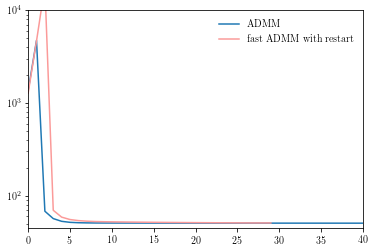

In [21]:
plt.plot(cost0, label="ADMM")
plt.plot(cost2, label="fast ADMM with restart")
plt.legend(loc='best')
plt.yscale('log')
plt.ylim([45,1E4])
plt.xlim([0,40])

#plt.savefig("../plots/2016-12-15-testing-algorithms-fake-data.pdf")

In [22]:
print(decon2.cost(gsol0, -decon2.A.dot(gsol0)+decon0.c, (fitflux_sub,)))
print(decon2.cost(gsol2, -decon2.A.dot(gsol2)+decon2.c, (fitflux_sub,)))
print(decon2.cost(realg.ravel(), -decon2.A.dot(realg.ravel())+decon2.c, (fitflux_sub,)))

50.33428757172118
50.76440981389195
51.12723701792209


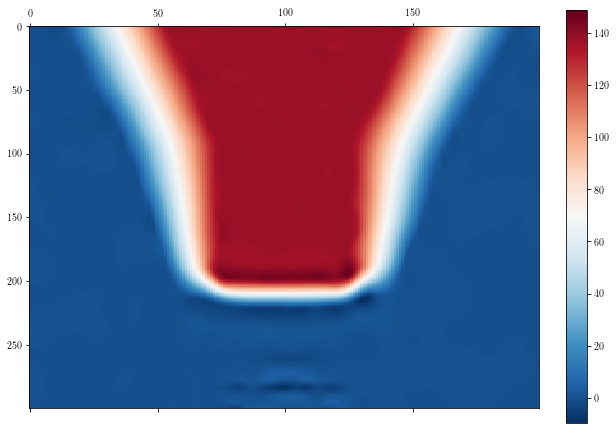

(<Figure size 720x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fdea13fb7b8>)

In [93]:
matshow((gsol0).reshape(kernel.Ly_pad,-1) + netmodel.g_ext, 0.5)
#matshow((gsol2).reshape(model.Ly_pad,-1)+netmodel.ext_g, 0.5)

In [26]:
model.updateParamVector(admm._g, ['gfieldflat'])
model.computeNLL()

-149556.26531529371

In [27]:
reload(fpd)

<module 'pysquid.viz.fake_data_plotting' from '/home/colin/work/rnet/code/pysquid/viz/fake_data_plotting.pyc'>

In [28]:
dfig, daxes = fpd.diagnostic(model, realg.reshape(model.Ly_pad,-1)+netmodel.ext_g, fakedata, admm)
#today = datetime.date(datetime.now()).isoformat()
#plt.savefig('../plots/{}-fake_data_diagnostic_mu-{}.pdf'.format(today, str(admm.mu_reg).replace('.','p')))

AttributeError: 'FluxModelTVPrior' object has no attribute 'modelflux'

In [77]:
np.savez('data/2016-03-03-fake-data-fit.npz', 
         g_sol=model.g_sol, ref_g = realg.reshape(model.Ly_pad,-1)+netmodel.ext_g,
         fit_flux = model.modelflux.reshape(model._shape), ref_flux = model.fluxdata,
         sigma = model.sigma, psf_params = model.kernel.psf_params, PSF=model.kernel.PSF)

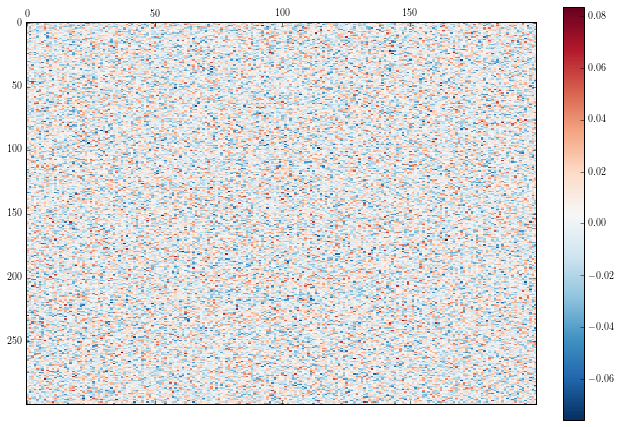

Pred mean: 0.000236388705665, Residual mean: 0.00542242604439 in sigmas


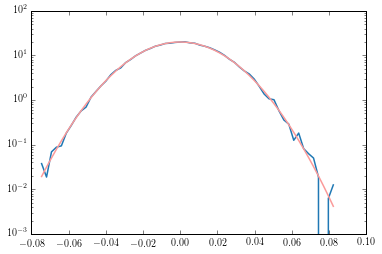

In [79]:
resim = model.residuals[:model.N].reshape(model.Ly, -1)
matshow(resim, aspect=0.5)#, vmin=-0.15, vmax=0.15)

hist, bins = np.histogram(resim, bins=60, density=True)
p = lambda x: np.exp(-(x/model.sigma)**2/2)/np.sqrt(2*np.pi*model.sigma**2)
resp = 0.5*(bins[1:]+bins[:-1])
plt.figure()
plt.plot(resp, hist)
plt.plot(resp, p(resp))
plt.yscale('log')
print("Pred mean: {}, Residual mean: {} in sigmas".format(resp.dot(p(resp)*np.diff(bins))/model.sigma, 
                                                          resp.dot(hist*np.diff(bins))/model.sigma))

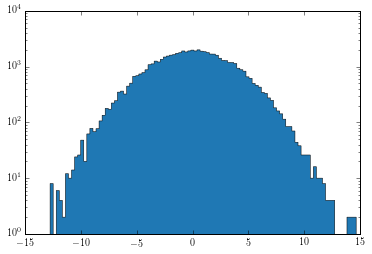

In [95]:
plt.hist(np.fft.fft2(resim).real.ravel(), bins=100, histtype='stepfilled');
plt.yscale('log')

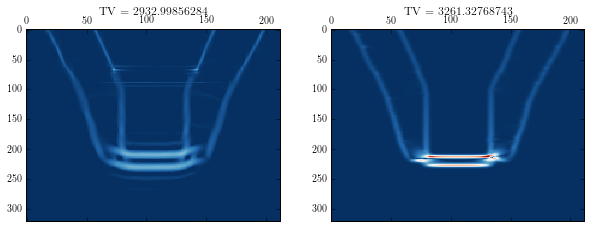

In [331]:
tv_modelg = admm.TV(model.gfield+model.extmodel.ext_g).reshape(model.Ly_pad,-1)
tv_realg = admm.TV(realg+model.extmodel.ext_g.ravel()).reshape(model.Ly_pad,-1)
fig, axes = plt.subplots(1,2, figsize=(10,5))
lim = max(tv_modelg.max(), tv_realg.max())
axes[0].matshow(tv_modelg, aspect=0.5, vmin=0, vmax=lim)
axes[0].set_title("TV = {}".format(tv_modelg.sum()))
axes[1].matshow(tv_realg, aspect=0.5, vmin=0, vmax = lim)
axes[1].set_title("TV = {}".format(tv_realg.sum()))

## Finite support

### Todo:


In [12]:
import scipy.ndimage as ndi

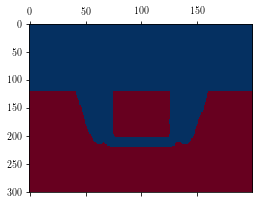

In [13]:
supportmask = mask[yc:yc+kernel.Ly_pad, xc:xc+kernel.Lx_pad]
#plt.matshow(supportmask, aspect=1/2.)
zeromask = ndi.binary_erosion(1*(supportmask == 0), iterations=2,
                              border_value=1)
zeromask[:120] = 0.
plt.matshow(zeromask, aspect=0.5)

In [14]:
#decon_fs = deconvolve.TVFiniteSupportDeconvolve(model.kernel, admm.mu, zeromask,
#                                                g_ext=model.extmodel.ext_g)

In [122]:
run ../pysquid/infercurrents/deconvolve.py

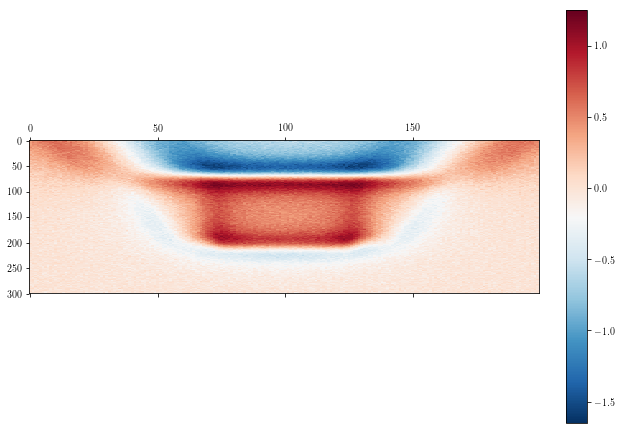

(<Figure size 720x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fadb2da16a0>)

In [140]:
matshow(fitflux_sub.reshape(kernel._shape))

In [123]:
decon_fs = TVDeconvolver(kernel, param_dict['sigma'][0], support_mask=zeromask,
                         g_ext=netmodel.g_ext)

In [124]:
labels, num = label(zeromask)

In [125]:
sizes = [zeromask[labels==i].sum() for i in list(range(1, num+1))]

In [126]:
decon_fs._F.sum(0).max()

161.4280025274928

In [127]:
costfs = []
def callback(x, z, y, costlist = costfs, **kwargs):
    costlist += [decon_fs.cost(x, z, (fitflux_sub,))]
    #costlist += [x, z, y]
    
#n = decon_fs._F.shape[1]
#x0 = np.random.randn(n)/np.sqrt(n) * decon_fs._F.sum(0)
    
gsol = decon_fs.deconvolve(fitflux_sub,
                           iprint=2, itnlim=30,
                           eps_abs=1E-6, eps_rel=1E-6, rho=1E-4,
                           algorithm='minimize', callback=callback)

Initial cost = 2.208e+03
Itn 0: cost = 5.675e+04, rho = 0.0002
	r = 1.171e+12, s = 1.758e-01 
Itn 1: cost = 6.883e+03, rho = 0.0004
	r = 8.405e+04, s = 6.997e-01 
Itn 2: cost = 7.757e+01, rho = 0.0008
	r = 7.629e+03, s = 7.511e-04 
Itn 3: cost = 7.306e+01, rho = 0.0016
	r = 1.271e+03, s = 7.160e-04 
Itn 4: cost = 7.219e+01, rho = 0.0032
	r = 2.290e+02, s = 6.477e-04 
Itn 5: cost = 7.197e+01, rho = 0.0064
	r = 3.808e+01, s = 5.923e-04 
Itn 6: cost = 7.187e+01, rho = 0.0128
	r = 5.999e+00, s = 5.296e-04 
Itn 7: cost = 7.181e+01, rho = 0.0256
	r = 9.739e-01, s = 5.220e-04 
Itn 8: cost = 7.178e+01, rho = 0.0512
	r = 1.655e-01, s = 5.060e-04 
Itn 9: cost = 7.176e+01, rho = 0.1024
	r = 2.480e-02, s = 5.157e-04 
Itn 10: cost = 7.175e+01, rho = 0.1024
	r = 3.281e-03, s = 5.120e-04 
Itn 11: cost = 7.174e+01, rho = 0.1024
	r = 8.656e-04, s = 4.980e-04 
Itn 12: cost = 7.173e+01, rho = 0.1024
	r = 4.891e-04, s = 4.908e-04 
Itn 13: cost = 7.172e+01, rho = 0.1024
	r = 3.797e-04, s = 4.754e-04 
Itn 1

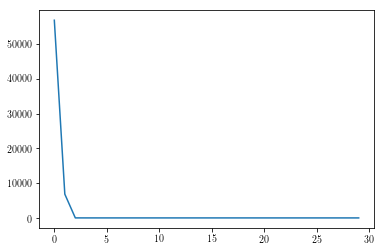

In [128]:
plt.plot(costfs) #;plt.yscale('log')

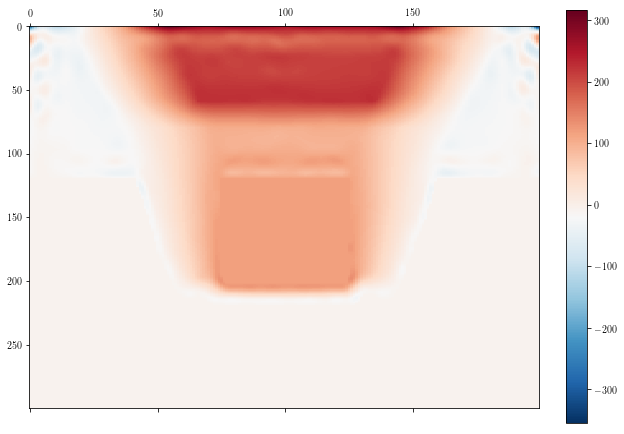

(<Figure size 720x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fadd1026748>)

In [132]:
#matshow((gsol0).reshape(Ly_pad, Lx_pad)+netmodel.ext_g, 0.5)
matshow(gsol.reshape(kernel._padshape) + netmodel.g_ext, 0.5)

In [33]:
print(decon_fs.g(gsol, (fitflux_sub)))
print(decon_fs.g(gsol0, (fitflux_sub)))
print(decon_fs.g(realg, (fitflux_sub)))

50.6534487757
51.2354119593
50.7646237303
